# Imports

In [69]:
# Importing required libraries

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


# Load Dataset

In [70]:
df = pd.read_csv("diabetes.csv")

# Display the first few rows
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Data Exploration and Cleaning

In [71]:
# Check for missing values
df.info()
print("\nMissing values per column:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
A

In [72]:
# Summary statistics
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


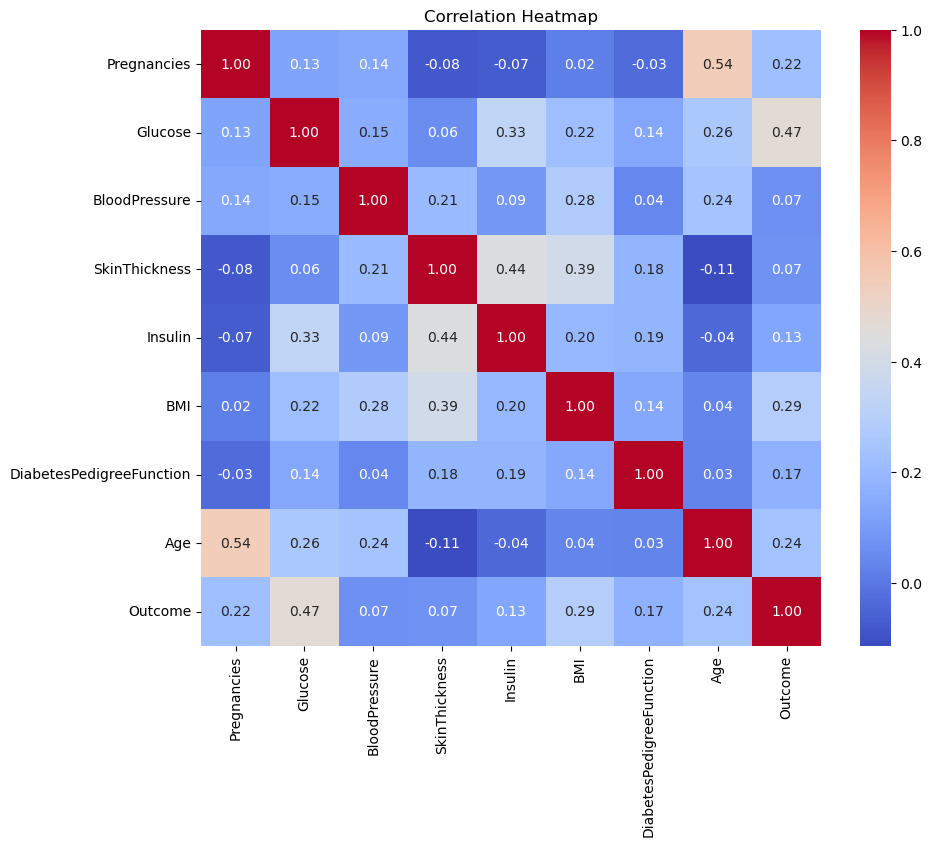

In [73]:
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

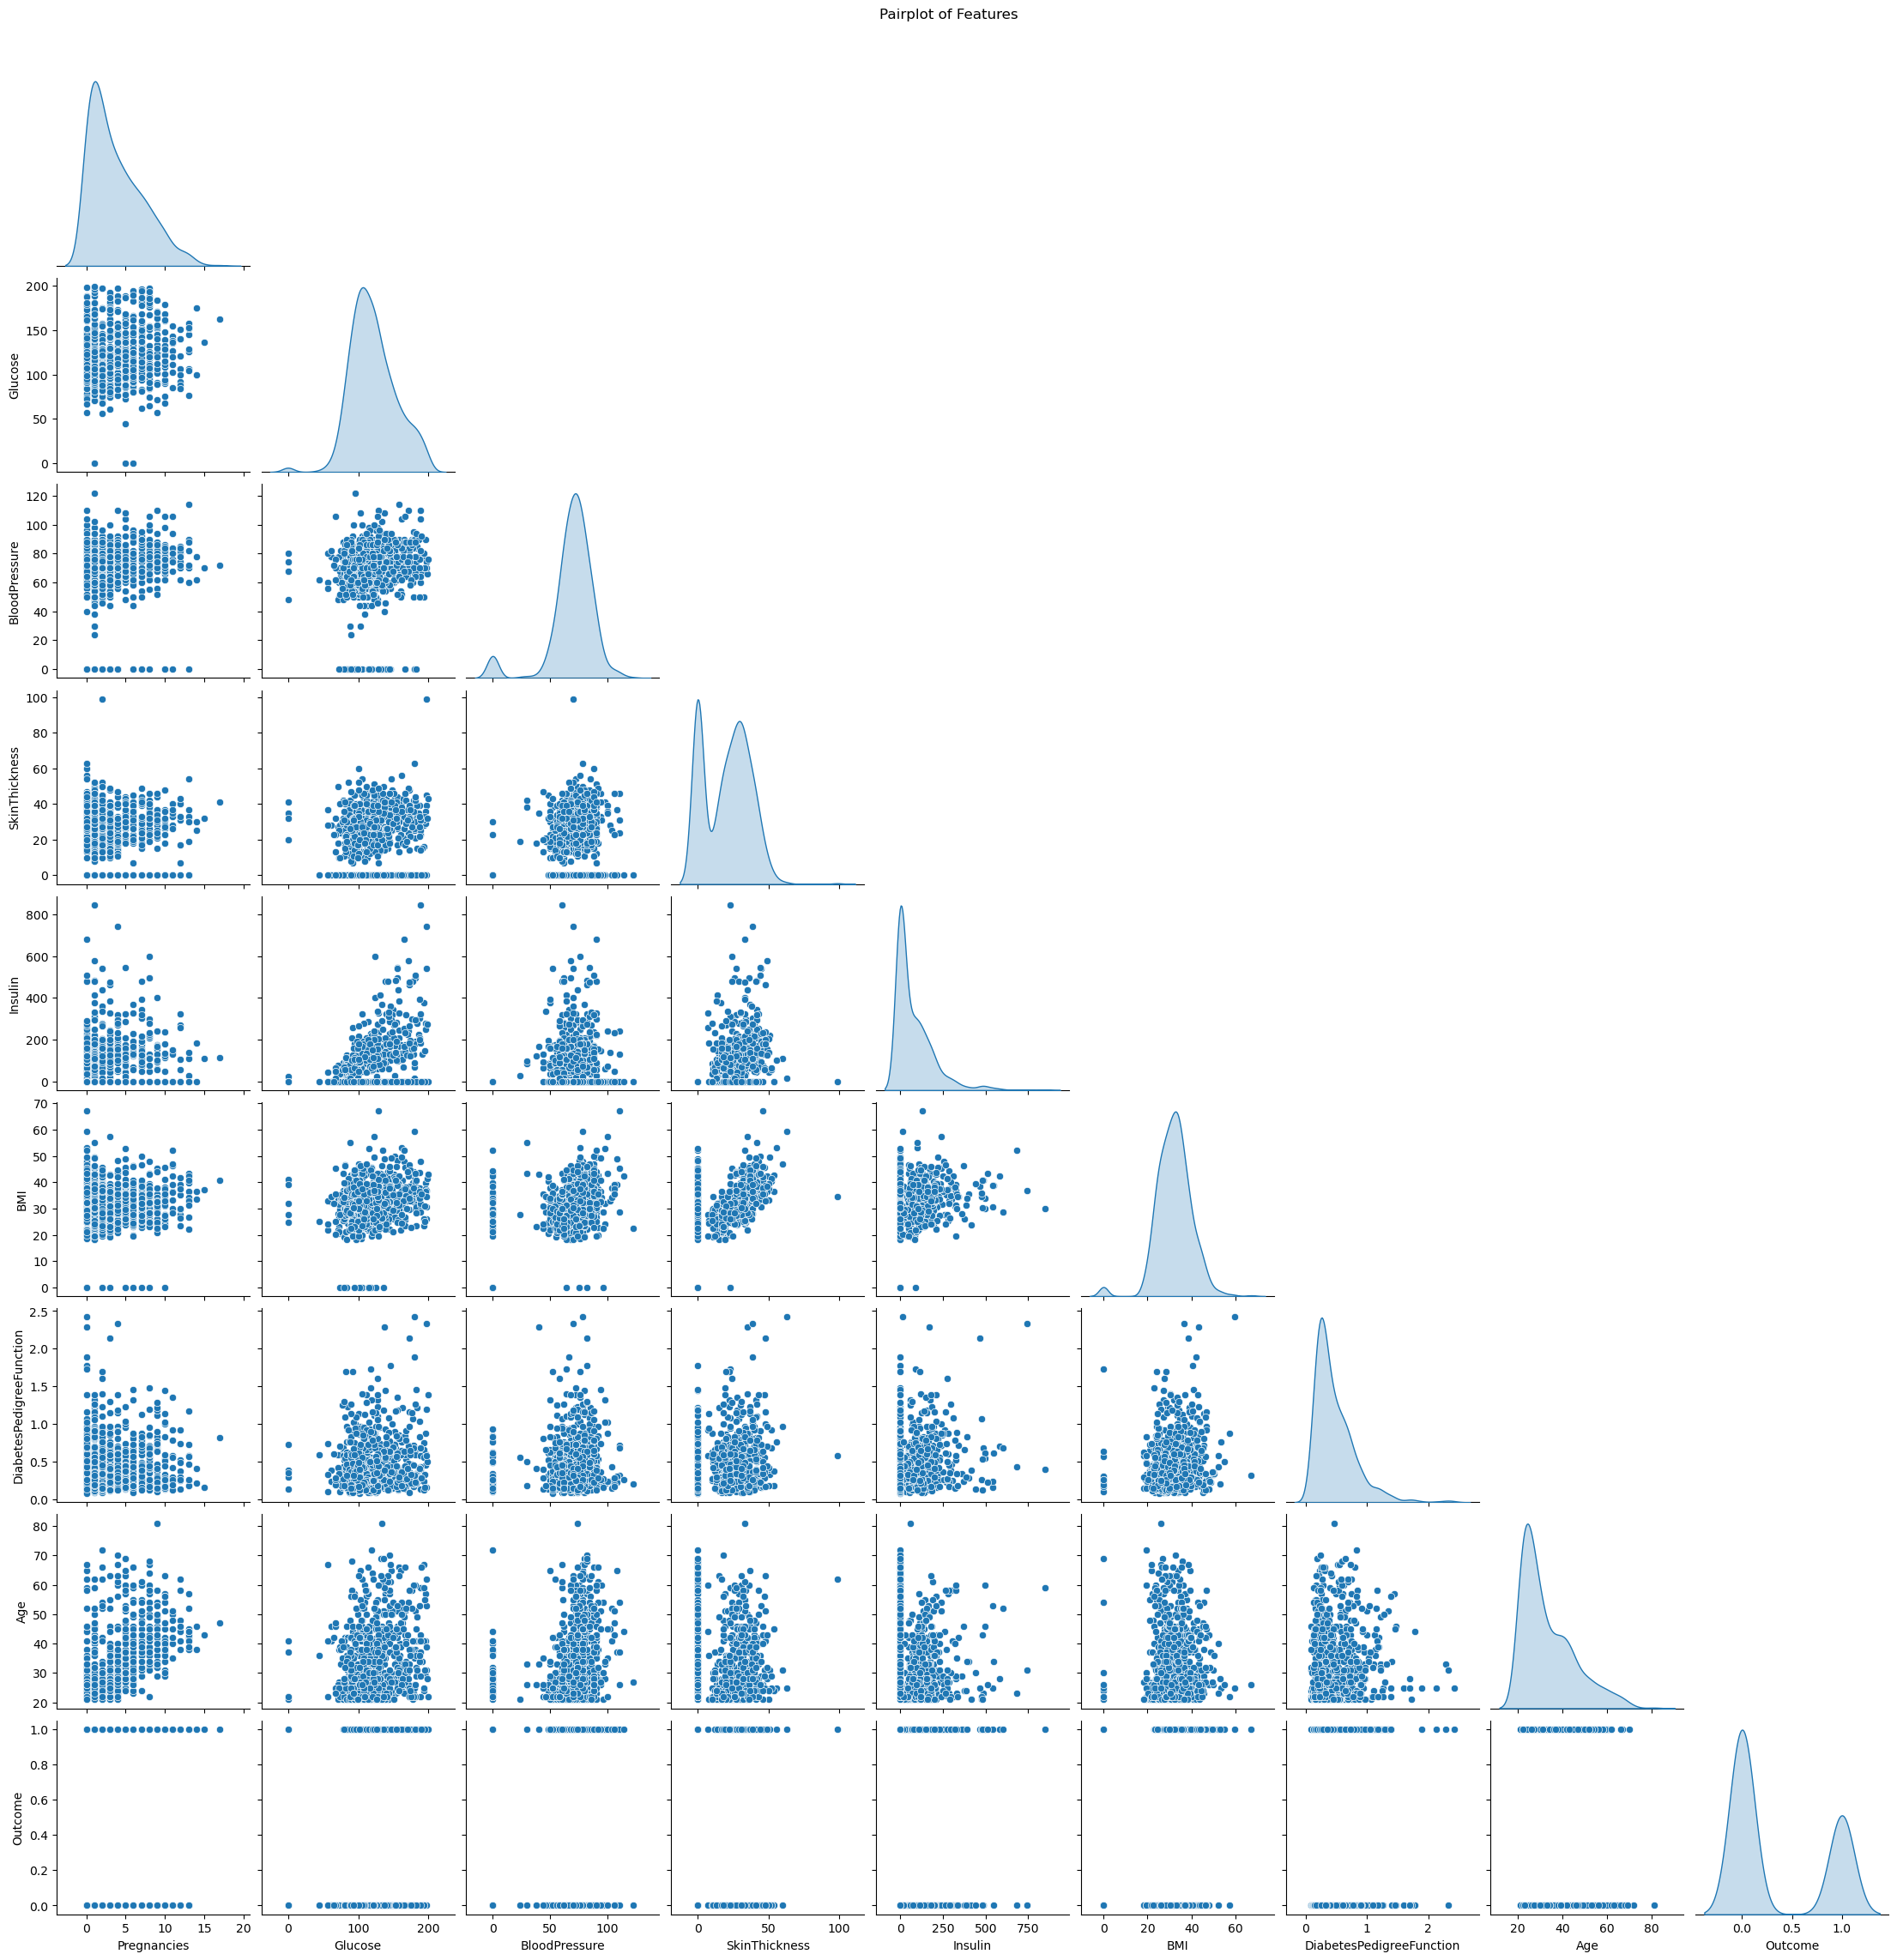

In [74]:
sns.pairplot(df, diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Features', y=1.02)
plt.show()


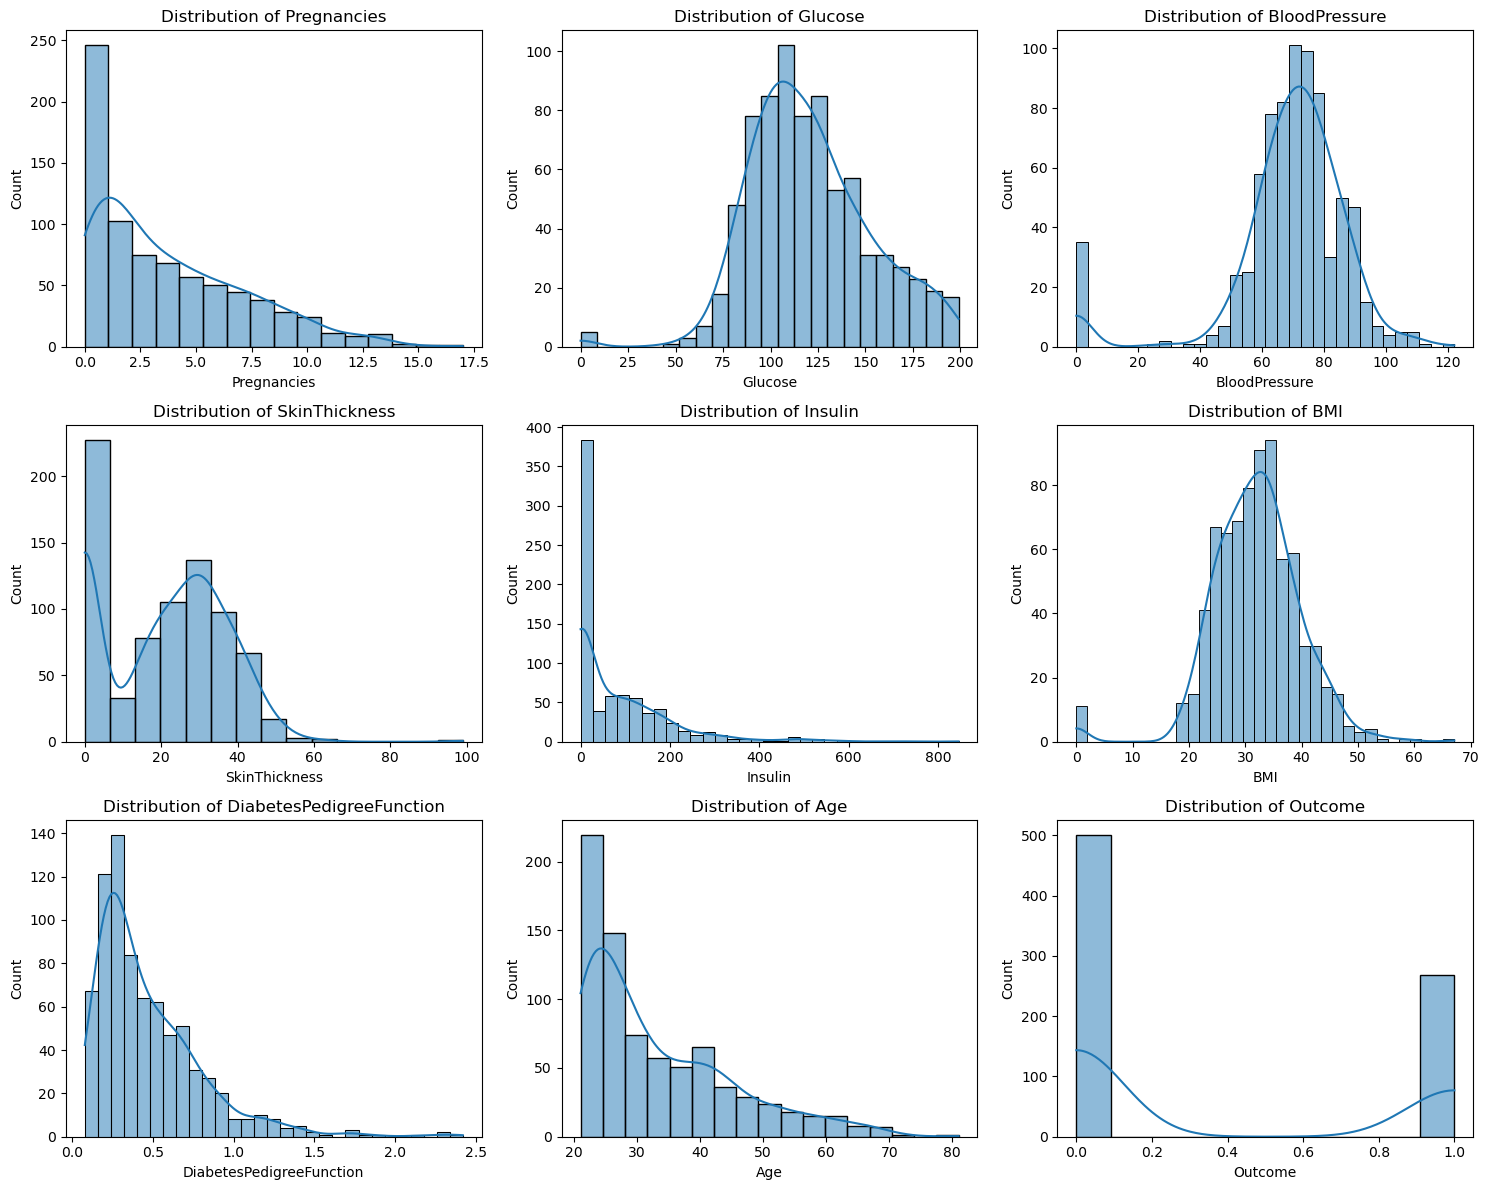

In [75]:
# Number of features
features = df.columns
num_features = len(features)

# Create a grid of subplots
rows = (num_features + 2) // 3  # Adjust rows based on the number of features
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 4))  # 3 columns per row

# Loop through each feature and plot
for i, column in enumerate(features):
    row, col = divmod(i, 3)  # Determine the position in the grid
    ax = axes[row, col]
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}')

# Remove empty subplots (if any)
for i in range(num_features, rows * 3):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

# Clean Data

In [76]:
# Replace zero values with NaN for relevant columns
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_columns] = df[zero_columns].replace(0, np.nan)

for column in zero_columns:
    df[column].fillna(df[column].median(), inplace = True)

C:\Users\Apoorv\AppData\Local\Temp\ipykernel_49888\569002550.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace = True)


In [77]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


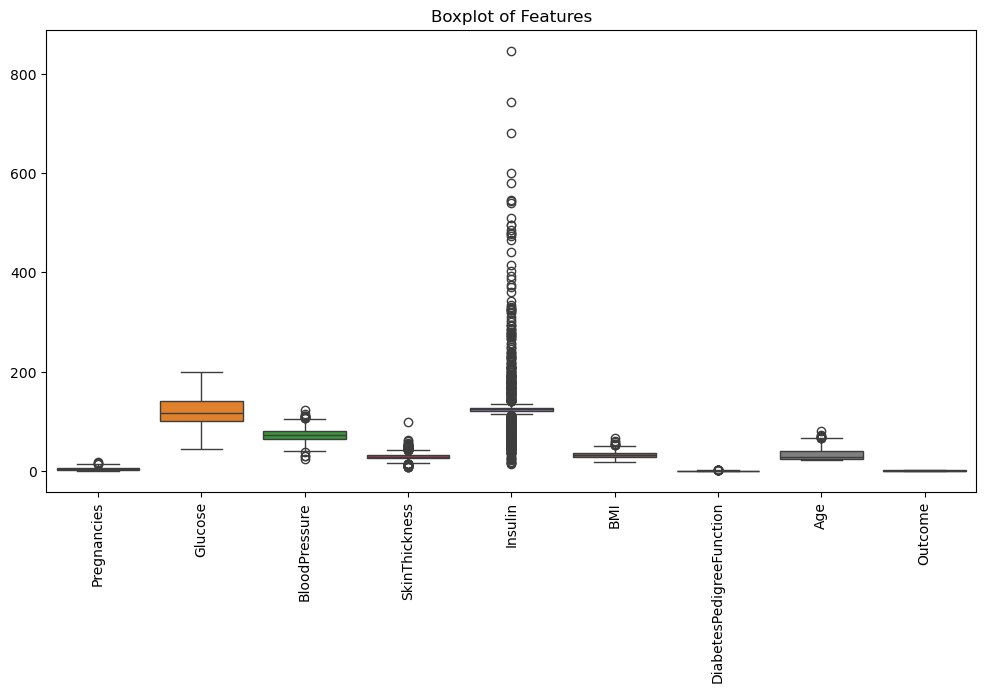

In [78]:
# Boxplots for each feature
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Boxplot of Features')
plt.show()


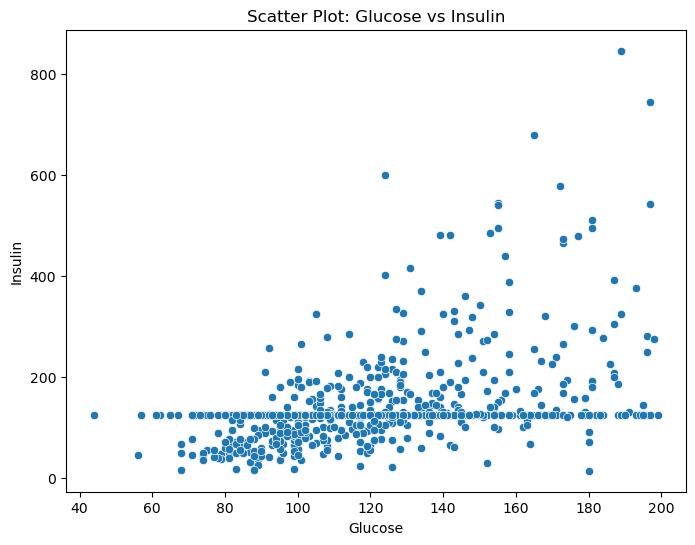

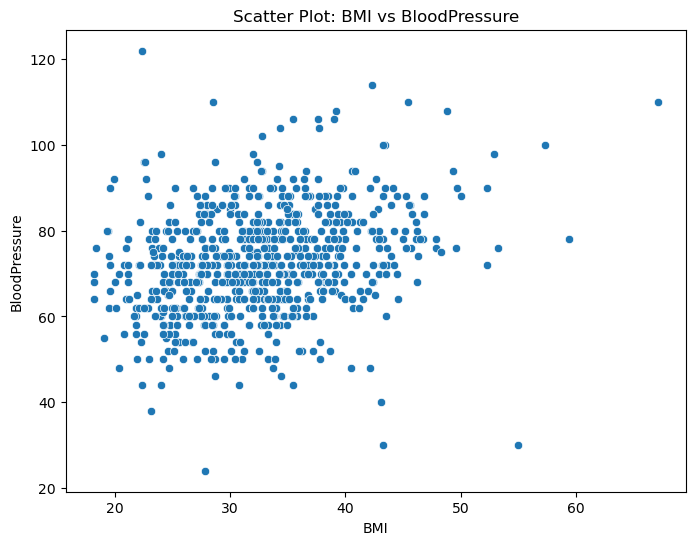

In [79]:
# Example: Relationship between Glucose and Insulin
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Glucose', y='Insulin', data=df)
plt.title('Scatter Plot: Glucose vs Insulin')
plt.show()

# Example: Relationship between BMI and BloodPressure
plt.figure(figsize=(8, 6))
sns.scatterplot(x='BMI', y='BloodPressure', data=df)
plt.title('Scatter Plot: BMI vs BloodPressure')
plt.show()


# Feature Engineering
## Feature Scaling

In [80]:
# Standardization (Z-score normalization because we are predicting a boolean outcome with a logistic regression)
scaler = StandardScaler()
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']] = scaler.fit_transform(
    df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
)


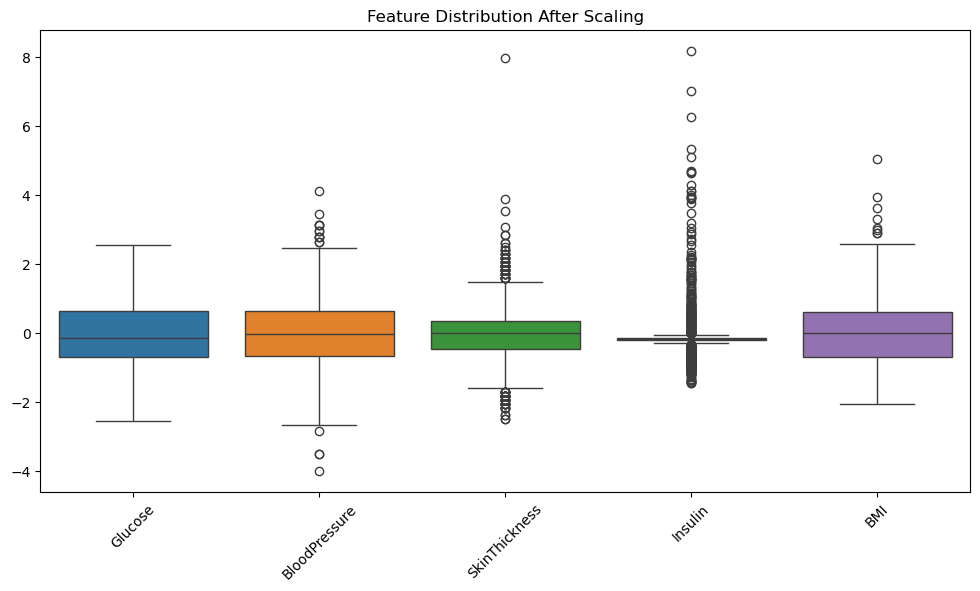

In [81]:
# Boxplot to check scaled feature distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']])
plt.xticks(rotation=45)
plt.title("Feature Distribution After Scaling")
plt.show()

# Defining Features and Targets

In [82]:

X = df.drop(columns=['Outcome'])
y = df['Outcome']

# Handling Class Imbalance (SMOTE)

In [83]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Before SMOTE:")
print(y.value_counts())
print("\nAfter SMOTE:")
print(pd.Series(y_resampled).value_counts())

Before SMOTE:
Outcome
0    500
1    268
Name: count, dtype: int64

After SMOTE:
Outcome
1    500
0    500
Name: count, dtype: int64


C:\Users\Apoorv\AppData\Local\Temp\ipykernel_49888\1837415316.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='viridis')


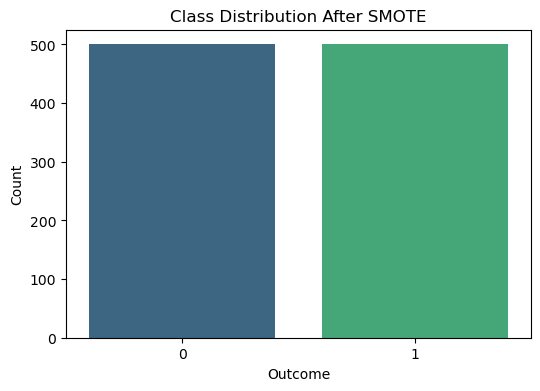

In [84]:
# Bar plot to visualize class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled, palette='viridis')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()

## Train Test Split

In [85]:
X_resampled


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,0.866045,-0.031990,0.670643,-0.181541,0.166619,0.468492,1.425995
1,1,-1.205066,-0.528319,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672
2,8,2.016662,-0.693761,-0.012301,-0.181541,-1.332500,0.604397,-0.105584
3,1,-1.073567,-0.528319,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549
4,0,0.504422,-2.679076,0.670643,0.316566,1.549303,5.484909,-0.020496
...,...,...,...,...,...,...,...,...
995,7,1.247472,-1.126336,0.193415,0.167389,-0.290358,0.104569,0.388548
996,3,0.010204,0.316665,-0.339650,-0.476587,-0.382357,-0.619456,-0.277178
997,2,1.730591,1.161305,-0.191522,0.101169,0.175590,1.900121,1.596171
998,2,-1.014159,-0.309465,1.485783,-0.140405,0.800889,0.127797,-0.521867


In [86]:
from sklearn.model_selection import train_test_split

# Split the dataset with selected features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)



## Hyperparameter Tuning 
Using: 
- Recursive tuning with 3 recursions
- Cross-Validation 
- GridSearch

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Logistic Regression
param_grid_tuning = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga']
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga']
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.5, 0.7, 0.9]
    }
]

# Initialize the Logistic Regression model
logistic_regression = LogisticRegression(max_iter=5000, class_weight='balanced')

# Perform GridSearchCV to find the best hyperparameters for Logistic Regression
grid_search_tuning = GridSearchCV(
    logistic_regression,
    param_grid_tuning,
    cv=10,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
grid_search_tuning.fit(X_resampled, y_resampled)

# Get the best Logistic Regression model
best_logistic_regression = grid_search_tuning.best_estimator_

print(f"Best Logistic Regression Parameters: {grid_search_tuning.best_params_}")
print(f"Best Logistic Regression Accuracy: {grid_search_tuning.best_score_:.4f}")


Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best Logistic Regression Accuracy: 0.8385


# Model Evaluation

              precision    recall  f1-score   support

           0       0.79      0.71      0.75       100
           1       0.74      0.81      0.77       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200

ROC-AUC Score: 0.8375


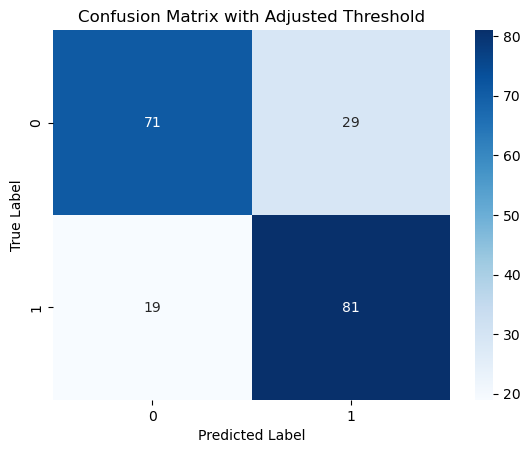

In [88]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Predict probabilities and class labels on the test set
y_proba = best_logistic_regression.predict_proba(X_test)[:, 1]
threshold = 0.45  # Adjust this value to control recall and precision
y_pred_adjusted = (y_proba >= threshold).astype(int)


# Evaluate model performance
print(classification_report(y_test, y_pred_adjusted))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix with Adjusted Threshold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Saving the model

In [89]:
import joblib

# Save the model to a file
joblib.dump(best_logistic_regression, 'diabetes_model_all_features.joblib')


['diabetes_model_all_features.joblib']